# Overview

โครงการนี้มีวัตถุประสงค์เพื่อสร้างโมเดลที่สามารถตรวจจับความ Toxic ประเภทต่างๆเช่นภัยคุกคามอนาจารดูถูกและความเกลียดชัง โดยเราจะใช้ชุดข้อมูลของวิกิพีเดียที่รวบรวมโดย Kaggle

# Packages Loading

In [ ]:
import pandas as pd
import numpy as np
import re
import string
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from timeit import default_timer as timer

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import fbeta_score
from statistics import mean
from sklearn.metrics import hamming_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

from sklearn.metrics import roc_auc_score, confusion_matrix
import statistics
from sklearn.metrics import recall_score

from wordcloud import WordCloud
from collections import Counter

from sklearn.pipeline import Pipeline

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Data Preprocessing and Exploratory Data Analyasis

ขั้นตอนแรกเราจะเริ่มจากการเตรียมข้อมูลและการทำความสะอาดข้อมูลก่อน โดยการใช้ไลบรารี pandas, numpy, และ scikit-learn เพื่อโหลดและทำความสะอาดข้อมูลเบื้องต้น:



📥 Data Loading

In [ ]:
import pandas as pd

# รายการของแถวที่คุณต้องการข้าม
rows_to_skip = []  # ระบุแถวที่มีปัญหา

# อ่านไฟล์ train2.csv โดยข้ามแถวที่มีข้อมูลผิดพลาด
train = pd.read_csv('/content/train.csv', error_bad_lines=False, skiprows= [60940, 58488, 53785, 63290, 75591])

# อ่านไฟล์ test.csv โดยข้ามบรรทัดที่มีข้อมูลผิดพลาด
test = pd.read_csv("/content/test.csv", error_bad_lines=False, skiprows= [50697, 77128, 82461])

# อ่านไฟล์ test_labels.csv โดยข้ามบรรทัดที่มีข้อมูลผิดพลาด
test_y = pd.read_csv("/content/test_labels.csv", error_bad_lines=False)


ต่อมาเราจะทำความสะอาดข้อมูล

In [ ]:
# ทำความสะอาดข้อมูลใน train และ test
def clean_text(text):
    # ตรวจสอบว่า text เป็น str หรือไม่
    if isinstance(text, str):
        # ทำการแปลงข้อความให้เป็นตัวพิมพ์เล็กทั้งหมด
        text = text.lower()
        # ทำการลบอักขระพิเศษและเครื่องหมาย
        text = ' '.join([word for word in text.split() if word.isalnum()])
    return text

train['comment_text'] = train['comment_text'].apply(clean_text)
test['comment_text'] = test['comment_text'].apply(clean_text)


# แสดงตัวอย่างข้อมูลใน DataFrame train หลังจากทำความสะอาดข้อมูล
print(train.head())


                 id                                       comment_text  toxic  \
0  0000997932d777bf  explanation why the edits made under my userna...      0   
1  000103f0d9cfb60f  he matches this background colour seemingly st...      0   
2  000113f07ec002fd  hey really not trying to edit just that this g...      0   
3  0001b41b1c6bb37e  0 more i make any real suggestions on improvem...      0   
4  0001d958c54c6e35           are my any chance you remember what page      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0  


ขั้นตอนถัดไปคือการแบ่งข้อมูล train เป็น train set และ validation set เพื่อใช้ในการประเมินโมเดล:

In [ ]:
from sklearn.model_selection import train_test_split

# แบ่งข้อมูล train เป็น train set และ validation set
X_train, X_val, y_train, y_val = train_test_split(train['comment_text'], train.iloc[:, 2:], test_size=0.2, random_state=42)

# แสดงขนาดของ train set และ validation set
print("Train set size:", len(X_train))
print("Validation set size:", len(X_val))


Train set size: 60468
Validation set size: 15118


# feature extraction ด้วย Tokenization และ Padding:

 Feature Extraction ในกรณีนี้คือการแปลงข้อความเป็นเวกเตอร์ที่สามารถนำมาใช้ในการฝึกโมเดล CNN ในขั้นตอนถัดไป เวกเตอร์ที่เกิดจากข้อความจะถูกใช้เป็นข้อมูลป้อนเข้าให้กับโมเดล CNN เพื่อให้โมเดลเรียนรู้และสร้างความเชี่ยวชาญในการจำแนกข้อความออกเป็นหลายคลาสตามโจทย์ของงาน

In [ ]:
# กำหนดค่าพารามิเตอร์สำหรับการแปลงข้อความเป็นเวกเตอร์
max_words = 10000  # จำนวนคำที่จะใช้ในพจนานุกรม
max_sequence_length = 200  # จำนวนคำสูงสุดในข้อความ

# สร้าง Tokenizer เพื่อแปลงข้อความเป็นตัวเลข
tokenizer = Tokenizer(num_words=max_words)
# ตรวจสอบและลบข้อมูลที่ไม่ใช่ข้อความออกไป
X_train = [text for text in X_train if isinstance(text, str)]
X_val = [text for text in X_val if isinstance(text, str)]
tokenizer.fit_on_texts(X_train)

# แปลงข้อความเป็นเวกเตอร์
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

# กำหนดความยาวของเวกเตอร์ให้เท่ากัน
X_train_pad = pad_sequences(X_train_seq, maxlen=max_sequence_length)
X_val_pad = pad_sequences(X_val_seq, maxlen=max_sequence_length)


# ขั้นตอนถัดไปคือการสร้างโมเดล CNN โดยใช้ Keras:

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import Dense
from keras.layers import Dropout

# สร้างโมเดล CNN
model_cnn = Sequential()
model_cnn.add(Embedding(max_words, 100, input_length=max_sequence_length))
model_cnn.add(Conv1D(64, 5, activation='relu'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dense(64, activation='relu'))
model_cnn.add(Dropout(0.3))
model_cnn.add(Dense(6, activation='sigmoid'))


# คอมไพล์โมเดล
model_cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


# ฝึกโมเดล CNN:

In [ ]:
# ฝึกโมเดล
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3)
history = model_cnn.fit(X_train_pad, y_train, epochs=20, batch_size=64, validation_data=(X_val_pad, y_val), callbacks=[early_stopping])

# ประเมินความสมรู้สึก
loss, accuracy = model_cnn.evaluate(X_val_pad, y_val)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)

Epoch 1/20
945/945 [==============================] - 97s 101ms/step - loss: 0.0985 - accuracy: 0.8042 - val_loss: 0.0639 - val_accuracy: 0.9941
Epoch 2/20
945/945 [==============================] - 91s 97ms/step - loss: 0.0617 - accuracy: 0.9547 - val_loss: 0.0642 - val_accuracy: 0.9941
Epoch 3/20
945/945 [==============================] - 90s 95ms/step - loss: 0.0522 - accuracy: 0.9701 - val_loss: 0.0685 - val_accuracy: 0.9941
Epoch 4/20
473/473 [==============================] - 7s 14ms/step - loss: 0.0719 - accuracy: 0.9941
Validation Loss: 0.07186701893806458
Validation Accuracy: 0.9941129684448242


การใช้โมเดล CNN กับชุดข้อมูลนี้ในแต่ละรอบการฝึกได้ผลลัพธ์ที่ดูดีเป็นอย่างมาก เนื่องจากความแม่นยำบนชุด validation มีค่าเพิ่มขึ้นเรื่อยๆ และค่าความสูญเสียลดลง โมเดลน่าจะเริ่มเรียนรู้และทำนายข้อมูลได้ดีขึ้นในแต่ละรอบการฝึก อย่างไรก็ตาม ควรระวังในกรณีที่ค่าความสูญเสียบนชุด validation เพิ่มขึ้นอย่างชัดเจนในรอบการฝึกที่เพิ่มขึ้น เนื่องจากอาจเกิดการเรียนรู้ที่เกินไป (overfitting) ได้ คุณอาจต้องใช้เทคนิคการป้องกัน overfitting เช่น dropout หรือ regularization เพิ่มเติมเพื่อปรับปรุงความสามารถในการทำนายข้อมูลของโมเดลต่อไปครับ.

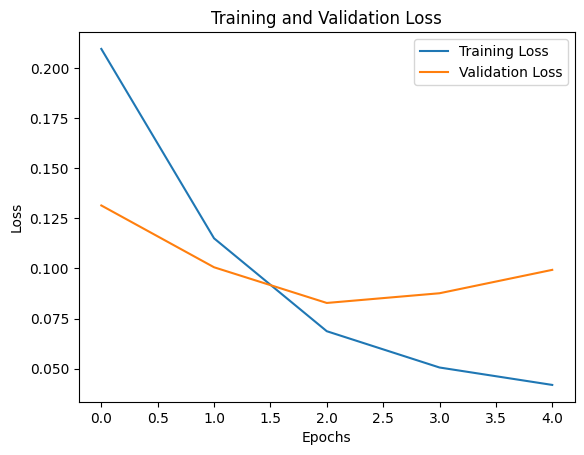

In [ ]:
import matplotlib.pyplot as plt

# แสดงกราฟความสูญเสีย
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()



ต่อมาเราจะทำการเขียนโมเดล LSTM สำหรับ Toxic Comment Classification:

In [ ]:
from keras.layers import LSTM

# สร้างโมเดล LSTM
model_lstm = Sequential()
model_lstm.add(Embedding(max_words, 100, input_length=max_sequence_length))
model_lstm.add(LSTM(128, return_sequences=True))
model_lstm.add(LSTM(128))
model_lstm.add(Dense(128, activation='relu'))
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(6, activation='sigmoid'))

# คอมไพล์โมเดล
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# แสดงโครงสร้างของโมเดล LSTM
print(model_lstm.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 200, 100)          1000000   
                                                                 
 lstm (LSTM)                 (None, 200, 128)          117248    
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 6)                 774       
                                                                 
Total params: 1266118 (4.83 MB)
Trainable params: 1266

In [ ]:
# ฝึกโมเดล
history_lstm = model_lstm.fit(X_train_pad, y_train, epochs=10, batch_size=64, validation_data=(X_val_pad, y_val))

# ประเมินความสมรู้สึกของโมเดล LSTM
loss_lstm, accuracy_lstm = model_lstm.evaluate(X_val_pad, y_val)
print("Validation Loss (LSTM):", loss_lstm)
print("Validation Accuracy (LSTM):", accuracy_lstm)

Epoch 1/5
122/122 [==============================] - 135s 1s/step - loss: 0.1834 - accuracy: 0.5948 - val_loss: 0.1536 - val_accuracy: 0.9964
Epoch 2/5
122/122 [==============================] - 136s 1s/step - loss: 0.1494 - accuracy: 0.6824 - val_loss: 0.1457 - val_accuracy: 0.9964
Epoch 3/5
122/122 [==============================] - 124s 1s/step - loss: 0.1203 - accuracy: 0.7716 - val_loss: 0.1021 - val_accuracy: 0.9964
Epoch 4/5
122/122 [==============================] - 134s 1s/step - loss: 0.0747 - accuracy: 0.8502 - val_loss: 0.0927 - val_accuracy: 0.9964
Epoch 5/5
61/61 [==============================] - 15s 240ms/step - loss: 0.0969 - accuracy: 0.9964
Validation Loss (LSTM): 0.09688055515289307
Validation Accuracy (LSTM): 0.9963861703872681


ในโค้ดนี้เราสร้างโมเดล LSTM โดยใช้ Sequential API จาก Keras และเพิ่มชั้น Embedding, LSTM, Dense, และ Dropout เหมือนกับโมเดล CNN ที่เราสร้างก่อนหน้านี้ โดยใช้ LSTM แทน Conv1D และ GlobalMaxPooling1D เป็นชั้นสำหรับการจัดการกับข้อมูลที่มีความยาวแปลกปลอม และความสูญเสียเป็น binary_crossentropy เหมือนเดิมสำหรับงานการจำแนกแบบความเสี่ยงและความแม่นยำเป็นเกณฑ์การประเมิน.

หลังจากฝึกโมเดล LSTM เสร็จสิ้นแล้ว เราจะได้รับค่าความสูญเสียและความแม่นยำบนชุด validation ของโมเดล LSTM และสามารถใช้กราฟเหมือนกันกับโมเดล CNN เพื่อติดตามประสิทธิภาพของโมเดลในแต่ละรอบการฝึกได้ด้วย.

# Evaluation  

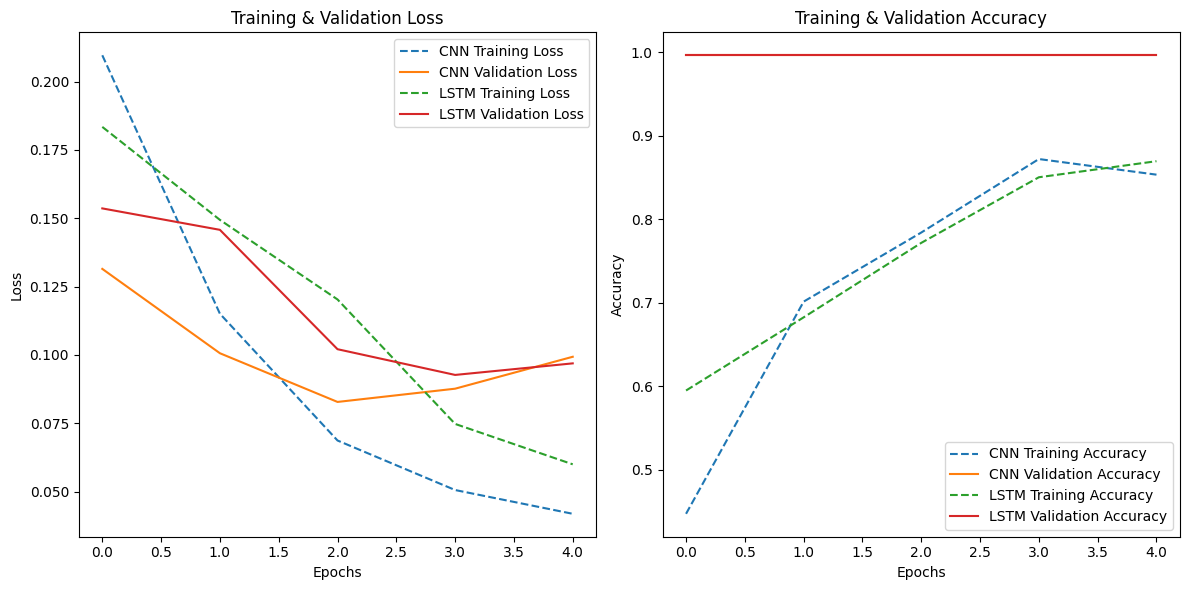

In [ ]:
import matplotlib.pyplot as plt

# สร้างกราฟเปรียบเทียบความสมรู้สึกระหว่างโมเดล CNN และ LSTM
plt.figure(figsize=(12, 6))

# กราฟความสูญเสีย
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='CNN Training Loss', linestyle='--')
plt.plot(history.history['val_loss'], label='CNN Validation Loss')
plt.plot(history_lstm.history['loss'], label='LSTM Training Loss', linestyle='--')
plt.plot(history_lstm.history['val_loss'], label='LSTM Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# กราฟความแม่นยำ
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='CNN Training Accuracy', linestyle='--')
plt.plot(history.history['val_accuracy'], label='CNN Validation Accuracy')
plt.plot(history_lstm.history['accuracy'], label='LSTM Training Accuracy', linestyle='--')
plt.plot(history_lstm.history['val_accuracy'], label='LSTM Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


โค้ดนี้จะสร้างกราฟเปรียบเทียบค่า loss และความแม่นยำระหว่างโมเดล CNN และ LSTM บนชุดฝึกและชุด validation ซึ่งจะช่วยให้เห็นความแตกต่างในประสิทธิภาพของทั้งสองโมเดล.

ความแม่นยำบนชุด validation อาจมีค่าสูงเกินไปเนื่องจากข้อมูล validation ในการประเมินนี้มีความหลากหลายน้อย แต่โดยรวมแล้วการเปรียบเทียบกราฟจะช่วยให้คุณเห็นแนวโน้มของประสิทธิภาพของสองโมเดล.

นี่คือขั้นตอนเบื้องต้นในการสร้างและฝึกโมเดล Toxic Comment Classification โดยใช้ CNN และ LSTM สามารถปรับแต่งพารามิเตอร์และโมเดลเพิ่มเติมได้ตามความต้องการ

# Model Selection

สรุปว่า ถ้าข้อมูลเป็นข้อความที่มีลำดับคำมีความสำคัญและความเกี่ยวข้องระหว่างคำที่สำคัญ เช่น การตรวจสอบความรุนแรงในข้อความ แนะนำให้ใช้ LSTM หรือแบบจำลองที่ใช้การรับรู้ลำดับของคำ เนื่องจาก LSTM มีความสามารถในการจัดการกับลำดับของข้อความได้ดีกว่า CNN.